# 데이터 취득 및 데이터 전처리 - 강범창

In [21]:
import requests
from bs4 import BeautifulSoup as bf
import pandas as pd
from tqdm import tqdm_notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
# 출처 서울 열린데이터 광장, 카카오 developer
#http://openapi.seoul.go.kr:8088/(인증키)/xml/CardBusStatisticsServiceNew/1/5/20151101/

In [2]:
date=pd.date_range('2019-1-1',periods=731,freq='D') # 2019-2020년 날짜
key='66696b6275746f7236336378485a52'# 서울 공공데이터 api 키
df_li=[]
for i in tqdm_notebook(date):
    j=str(i).split()[0].replace('-','')
    url='http://openapi.seoul.go.kr:8088/{}/json/CardSubwayStatsNew/1/900/{}'.format(key,j)
    resp=requests.get(url).json()
    df=pd.DataFrame(resp['CardSubwayStatsNew']['row'])
    df_li.append(df)
fi_df=pd.concat(df_li)
print(fi_df.shape)
station=fi_df['SUB_STA_NM'].unique()
len(station)

<ipython-input-2-4093a7b441a1>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(date):



(432824, 6)


521

In [3]:
def xy(url,x_li,y_li):
    resp=requests.get(url,headers={"Authorization":f"KakaoAK {kakao_key}"})
    content=resp.json()
    x_li.append(content['documents'][0]['x'])
    y_li.append(content['documents'][0]['y'])

In [4]:
def xy1(url,gu):
    resp=requests.get(url,headers={"Authorization":f"KakaoAK {kakao_key}"})
    content=resp.json()
    gu.append(content['documents'][0]['address_name'].split()[1])

In [5]:
def xy2(url):
    resp=requests.get(url,headers={"Authorization":f"KakaoAK {kakao_key}"})
    content=resp.json()
    return content['documents'][0]['address_name'].split()[0]=='서울'

In [6]:
kakao_key='5ada2bc5b69fcd7897c5b3c0db126933'# 카카오 키
x_li=[];y_li=[];add_li=[];comple_li=[];gu=[]# x,y,추가할 역, 있는 역
for i in tqdm_notebook(station):
    try:
        if i[-1]!='역':
            url="https://dapi.kakao.com/v2/local/search/?query={}".format(i+'역')
            if xy2(url):
                xy(url,x_li,y_li)
                xy1(url,gu)
                comple_li.append(i)
        else:
            url="https://dapi.kakao.com/v2/local/search/keyword?query={}".format(i)
            if xy2(url):
                xy(url,x_li,y_li)
                xy1(url,gu)
                comple_li.append(i)
    except:
        add_li.append(i)
print(len(x_li),len(y_li),len(gu))

<ipython-input-6-46744e3afe42>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(station):



1 1 1


In [7]:
li2=[]# 안된 것들 다시 하기
for i in tqdm_notebook(add_li):
    try:
        j=i.split('(')[0]
        url="https://dapi.kakao.com/v2/local/search/keyword?query={}".format(j+'역')
        if xy2(url):
            xy(url,x_li,y_li)
            xy1(url,gu)
            comple_li.append(i)
    except:
        li2.append(i)
print(len(x_li),len(y_li),len(gu),len(comple_li),len(li2))# 완성

<ipython-input-7-4b3ef24b18cd>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(add_li):



300 300 300 300 0


In [8]:
station_xy_df=pd.DataFrame({'역명':comple_li,'구명':gu,'x':x_li,'y':y_li})
station_xy_df.head()

,역명,구명,x,y
0,서울역,용산구,126.970606917394,37.5546788388674
1,시청,중구,126.97719821079865,37.56534539636417
2,종각,종로구,126.98315081716676,37.570227990912244
3,종로3가,종로구,126.992153252476,37.570420844523
4,종로5가,종로구,127.00153834521934,37.57097610838373


In [9]:
station_xy_df.to_csv('./정리/station_xy_gu.csv',encoding='cp949')

서울내에 있는 구 파악하기

In [7]:
gu=pd.read_csv('./정리/station_xy_gu.csv',encoding='cp949',index_col=0)
gu.rename(columns={gu.columns[0]:'SUB_STA_NM'},inplace=True)
gu.head()

,SUB_STA_NM,구명,x,y
0,서울역,용산구,126.970607,37.554679
1,시청,중구,126.977198,37.565345
2,종각,종로구,126.983151,37.570228
3,종로3가,종로구,126.992153,37.570421
4,종로5가,종로구,127.001538,37.570976


In [5]:
fi_df=pd.read_csv('./data/raw.csv',index_col=0)
fi_df.head()

,USE_DT2,LINE_NUM,SUB_STA_NM,RIDE_PASGR_NUM,ALIGHT_PASGR_NUM
0,201901,1호선,서울역,39420.0,31121.0
1,201901,1호선,시청,11807.0,10322.0
2,201901,1호선,종각,20944.0,16658.0
3,201901,1호선,종로3가,17798.0,15762.0
4,201901,1호선,종로5가,13578.0,13282.0


In [8]:
fi_df2=fi_df.merge(gu,on='SUB_STA_NM')
fi_df2=pd.DataFrame(fi_df2,columns=['USE_DT2','LINE_NUM','구명','SUB_STA_NM','RIDE_PASGR_NUM','ALIGHT_PASGR_NUM'])
fi_df2.head()

,USE_DT2,LINE_NUM,구명,SUB_STA_NM,RIDE_PASGR_NUM,ALIGHT_PASGR_NUM
0,201901,1호선,용산구,서울역,39420.0,31121.0
1,201901,4호선,용산구,서울역,5689.0,13266.0
2,201901,경부선,용산구,서울역,5983.0,731.0
3,201901,경의선,용산구,서울역,1278.0,919.0
4,201901,공항철도 1호선,용산구,서울역,14043.0,9955.0


In [13]:
fi_df3=fi_df2.pivot_table(index=['USE_DT2','구명'],aggfunc=np.sum)
fi_df3

ALIGHT_PASGR_NUM  RIDE_PASGR_NUM
USE_DT2 구명                                   
201901  강남구        20763155.0      19969853.0
        강동구         4529692.0       4643468.0
        강북구         3211648.0       3310639.0
        강서구         7103673.0       7437026.0
        관악구         5324536.0       5488288.0
...                       ...             ...
202012  용산구         4009697.0       4005965.0
        은평구         3841009.0       3940841.0
        종로구         5461095.0       5501670.0
        중구          6045862.0       5995432.0
        중랑구         2315799.0       2364761.0

[600 rows x 2 columns]

In [14]:
fi_df3.to_csv('./정리/month2.csv',encoding='cp949') # 구별 인구 합

# 그래프 및 데이터 확인 - 고준수
# 년별로 승하차수의 차이가 있을까??

In [47]:
csv_month=pd.read_csv('./정리/month2.csv',encoding='cp949')
csv_month.head()

,USE_DT2,구명,ALIGHT_PASGR_NUM,RIDE_PASGR_NUM
0,201901,강남구,20763155.0,19969853.0
1,201901,강동구,4529692.0,4643468.0
2,201901,강북구,3211648.0,3310639.0
3,201901,강서구,7103673.0,7437026.0
4,201901,관악구,5324536.0,5488288.0


In [48]:
csv_month.rename(columns={'USE_DT2':'날짜'},inplace=True)
csv_month['총승하차수']=csv_month['ALIGHT_PASGR_NUM']+csv_month['RIDE_PASGR_NUM']

In [49]:
csv_month.head()

,날짜,구명,ALIGHT_PASGR_NUM,RIDE_PASGR_NUM,총승하차수
0,201901,강남구,20763155.0,19969853.0,40733008.0
1,201901,강동구,4529692.0,4643468.0,9173160.0
2,201901,강북구,3211648.0,3310639.0,6522287.0
3,201901,강서구,7103673.0,7437026.0,14540699.0
4,201901,관악구,5324536.0,5488288.0,10812824.0


In [50]:
csv_month_2019 = csv_month[csv_month['날짜']<202000]
csv_month_2019.head()

,날짜,구명,ALIGHT_PASGR_NUM,RIDE_PASGR_NUM,총승하차수
0,201901,강남구,20763155.0,19969853.0,40733008.0
1,201901,강동구,4529692.0,4643468.0,9173160.0
2,201901,강북구,3211648.0,3310639.0,6522287.0
3,201901,강서구,7103673.0,7437026.0,14540699.0
4,201901,관악구,5324536.0,5488288.0,10812824.0


In [51]:
csv_month_2020 = csv_month[csv_month['날짜']>=202000]
csv_month_2020.head()

,날짜,구명,ALIGHT_PASGR_NUM,RIDE_PASGR_NUM,총승하차수
300,202001,강남구,19267648.0,18509432.0,37777080.0
301,202001,강동구,4425609.0,4531848.0,8957457.0
302,202001,강북구,3063191.0,3153484.0,6216675.0
303,202001,강서구,6773508.0,7035847.0,13809355.0
304,202001,관악구,4866716.0,5046961.0,9913677.0


In [18]:
# matplot에서 한글 폰트 정상화
import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False 
# 출처 페스트 켐퍼스

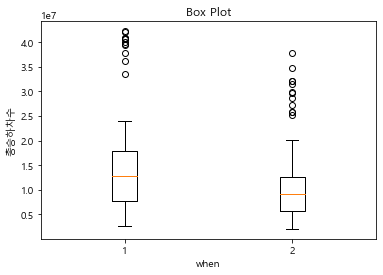

In [24]:
import matplotlib.pyplot as plt
plt.grid()
plt.boxplot([csv_month_2019['총승하차수'], csv_month_2020['총승하차수']])
plt.xlabel('when')
plt.ylabel('총승하차수')
plt.title('Box Plot')
plt.grid()
plt.show()

# 데이터 정규성 확인

<AxesSubplot:xlabel='총승하차수', ylabel='Density'>

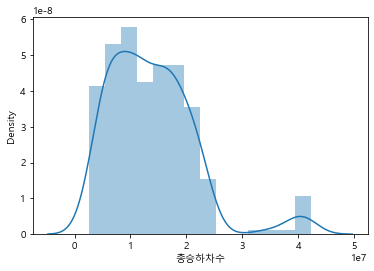

In [25]:
sns.distplot(csv_month_2019['총승하차수'])

<AxesSubplot:xlabel='총승하차수', ylabel='Density'>

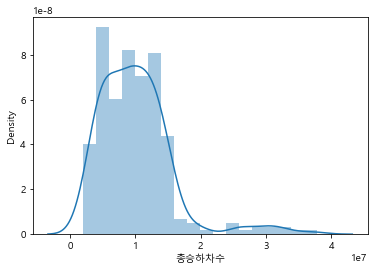

In [26]:
sns.distplot(csv_month_2020['총승하차수'])

((array([-2.83270147, -2.5363011 , -2.36847471, -2.24887944, -2.15478411,
         -2.07661294, -2.00938931, -1.95018201, -1.89711324, -1.84890481,
         -1.80464581, -1.76366326, -1.72544529, -1.68959313, -1.65578984,
         -1.62377915, -1.5933508 , -1.56433003, -1.53656998, -1.50994596,
         -1.48435118, -1.45969344, -1.43589258, -1.41287842, -1.39058917,
         -1.36897015, -1.34797267, -1.32755325, -1.30767283, -1.28829622,
         -1.26939159, -1.25093005, -1.23288529, -1.21523328, -1.19795202,
         -1.1810213 , -1.16442252, -1.1481385 , -1.13215338, -1.11645243,
         -1.10102199, -1.08584934, -1.07092263, -1.0562308 , -1.04176348,
         -1.02751099, -1.01346422, -0.99961462, -0.98595415, -0.97247524,
         -0.95917073, -0.94603388, -0.93305829, -0.92023793, -0.90756706,
         -0.89504026, -0.88265235, -0.87039844, -0.85827385, -0.84627414,
         -0.83439507, -0.82263259, -0.81098284, -0.79944213, -0.78800692,
         -0.77667384, -0.76543965, -0.

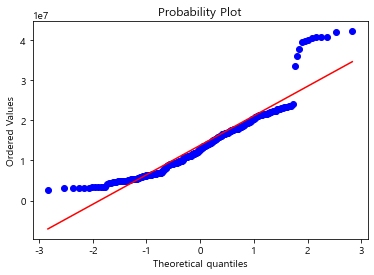

In [27]:
#2019년도 총승하차수 데이터 정규성 검정 by Q-Q plot
import scipy.stats as stats
stats.probplot(csv_month_2019['총승하차수'], plot=plt)

((array([-2.83270147, -2.5363011 , -2.36847471, -2.24887944, -2.15478411,
         -2.07661294, -2.00938931, -1.95018201, -1.89711324, -1.84890481,
         -1.80464581, -1.76366326, -1.72544529, -1.68959313, -1.65578984,
         -1.62377915, -1.5933508 , -1.56433003, -1.53656998, -1.50994596,
         -1.48435118, -1.45969344, -1.43589258, -1.41287842, -1.39058917,
         -1.36897015, -1.34797267, -1.32755325, -1.30767283, -1.28829622,
         -1.26939159, -1.25093005, -1.23288529, -1.21523328, -1.19795202,
         -1.1810213 , -1.16442252, -1.1481385 , -1.13215338, -1.11645243,
         -1.10102199, -1.08584934, -1.07092263, -1.0562308 , -1.04176348,
         -1.02751099, -1.01346422, -0.99961462, -0.98595415, -0.97247524,
         -0.95917073, -0.94603388, -0.93305829, -0.92023793, -0.90756706,
         -0.89504026, -0.88265235, -0.87039844, -0.85827385, -0.84627414,
         -0.83439507, -0.82263259, -0.81098284, -0.79944213, -0.78800692,
         -0.77667384, -0.76543965, -0.

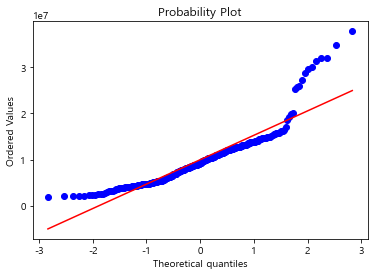

In [28]:
stats.probplot(csv_month_2020['총승하차수'], plot=plt)

In [29]:
#로그변환(데이터가 정규성을 만족하지 않기 때문에 로그변환을 한다.)
csv_month_2019['총승하차수']
csv_month_2019["Log_col"] = np.log1p(csv_month_2019['총승하차수'])
csv_month_2019.head()

,날짜,구명,ALIGHT_PASGR_NUM,RIDE_PASGR_NUM,총승하차수,Log_col
0,201901,강남구,20763155.0,19969853.0,40733008.0,17.522549
1,201901,강동구,4529692.0,4643468.0,9173160.0,16.031792
2,201901,강북구,3211648.0,3310639.0,6522287.0,15.690736
3,201901,강서구,7103673.0,7437026.0,14540699.0,16.492462
4,201901,관악구,5324536.0,5488288.0,10812824.0,16.196243


((array([-2.83270147, -2.5363011 , -2.36847471, -2.24887944, -2.15478411,
         -2.07661294, -2.00938931, -1.95018201, -1.89711324, -1.84890481,
         -1.80464581, -1.76366326, -1.72544529, -1.68959313, -1.65578984,
         -1.62377915, -1.5933508 , -1.56433003, -1.53656998, -1.50994596,
         -1.48435118, -1.45969344, -1.43589258, -1.41287842, -1.39058917,
         -1.36897015, -1.34797267, -1.32755325, -1.30767283, -1.28829622,
         -1.26939159, -1.25093005, -1.23288529, -1.21523328, -1.19795202,
         -1.1810213 , -1.16442252, -1.1481385 , -1.13215338, -1.11645243,
         -1.10102199, -1.08584934, -1.07092263, -1.0562308 , -1.04176348,
         -1.02751099, -1.01346422, -0.99961462, -0.98595415, -0.97247524,
         -0.95917073, -0.94603388, -0.93305829, -0.92023793, -0.90756706,
         -0.89504026, -0.88265235, -0.87039844, -0.85827385, -0.84627414,
         -0.83439507, -0.82263259, -0.81098284, -0.79944213, -0.78800692,
         -0.77667384, -0.76543965, -0.

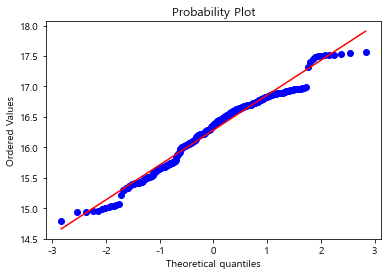

In [30]:
stats.probplot(csv_month_2019['Log_col'], plot=plt)

In [31]:
csv_month_2020["Log_col"] = np.log1p(csv_month_2020['총승하차수'])
csv_month_2020.head()

,날짜,구명,ALIGHT_PASGR_NUM,RIDE_PASGR_NUM,총승하차수,Log_col
300,202001,강남구,19267648.0,18509432.0,37777080.0,17.447213
301,202001,강동구,4425609.0,4531848.0,8957457.0,16.007997
302,202001,강북구,3063191.0,3153484.0,6216675.0,15.642746
303,202001,강서구,6773508.0,7035847.0,13809355.0,16.440857
304,202001,관악구,4866716.0,5046961.0,9913677.0,16.109426


((array([-2.83270147, -2.5363011 , -2.36847471, -2.24887944, -2.15478411,
         -2.07661294, -2.00938931, -1.95018201, -1.89711324, -1.84890481,
         -1.80464581, -1.76366326, -1.72544529, -1.68959313, -1.65578984,
         -1.62377915, -1.5933508 , -1.56433003, -1.53656998, -1.50994596,
         -1.48435118, -1.45969344, -1.43589258, -1.41287842, -1.39058917,
         -1.36897015, -1.34797267, -1.32755325, -1.30767283, -1.28829622,
         -1.26939159, -1.25093005, -1.23288529, -1.21523328, -1.19795202,
         -1.1810213 , -1.16442252, -1.1481385 , -1.13215338, -1.11645243,
         -1.10102199, -1.08584934, -1.07092263, -1.0562308 , -1.04176348,
         -1.02751099, -1.01346422, -0.99961462, -0.98595415, -0.97247524,
         -0.95917073, -0.94603388, -0.93305829, -0.92023793, -0.90756706,
         -0.89504026, -0.88265235, -0.87039844, -0.85827385, -0.84627414,
         -0.83439507, -0.82263259, -0.81098284, -0.79944213, -0.78800692,
         -0.77667384, -0.76543965, -0.

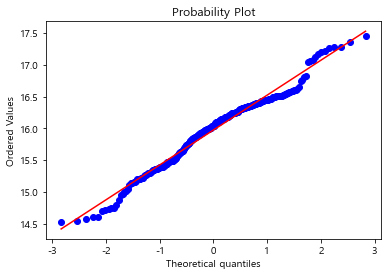

In [32]:
stats.probplot(csv_month_2020['Log_col'], plot=plt)

In [33]:
csv_month_2020.reset_index(inplace=True)
csv_month_2019.reset_index(inplace=True)

In [34]:
result_log = csv_month_2020['Log_col'] - csv_month_2019['Log_col']
t = result_log.mean()/(result_log.std()/3504**0.5) # t값
t

-119.44734232406425

In [35]:
from scipy.stats import ttest_1samp
ttest_1samp(result_log, 0)
# 교통량의 변화에 차이가 있다.(귀무가설 기각)

Ttest_1sampResult(statistic=-34.95063493784347, pvalue=1.3025788296201934e-107)

In [36]:
# 교통량 감소 비율
a = csv_month_2019['총승하차수'].sum()
b = csv_month_2020['총승하차수'].sum()
print((1-b/a)*100, "%") 

27.43301685992552 %


# 코로나와 지하철의 상관관계 - 김창현

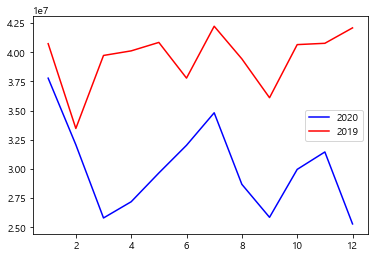

In [37]:
# 강남부터 확인해 보자
plot_month = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(plot_month,csv_month_2020[csv_month_2020['구명']=='강남구']['총승하차수'],color='blue',label='2020')
plt.plot(plot_month,csv_month_2019[csv_month_2019['구명']=='강남구']['총승하차수'],color='red',label='2019')
plt.legend()

# 선형회귀

In [38]:
from sklearn.linear_model import LinearRegression
## 서울시에서 가져온 서울시 코로나 월별 코로나 확진자
corona_gangnam=csv_month_2020[csv_month_2020['구명']=='강남구']['총승하차수'][3:]
corona_month = [4,5,6,7,8,9,10,11,12]
people_month = [979,703,1334,1506,5642,3865,2714,7768,26564]
x = np.array(corona_month).reshape(-1,1)
y = np.array(people_month)
line_fitter = LinearRegression()
line_fitter.fit(x, corona_gangnam)
corona_line_fitter = LinearRegression()
corona_line_fitter.fit(x, y)

LinearRegression()

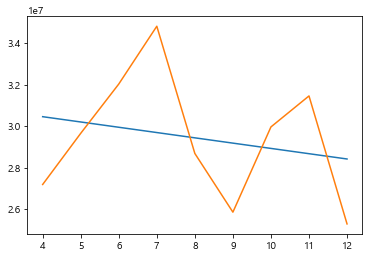

In [39]:
plt.plot(x, line_fitter.predict(x))
plt.plot(x, corona_gangnam)

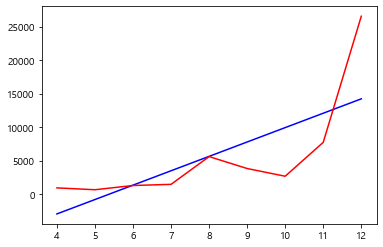

In [40]:
plt.plot(x, corona_line_fitter.predict(x), color = "blue")
plt.plot(x, y, color = "red")

#### 코로나 확진자, 강남구 승차 인원 상관관계

In [41]:
corr_df = pd.DataFrame({"corona_people" : people_month, "gangnam_people" : corona_gangnam.values}, index = corona_month)
corr_df.corr(method='pearson')

,corona_people,gangnam_people
corona_people,1.000000,-0.504859
gangnam_people,-0.504859,1.000000


In [42]:
corr_df

,corona_people,gangnam_people
4,979,27184809.0
5,703,29650072.0
6,1334,32025356.0
7,1506,34811121.0
8,5642,28678678.0
9,3865,25850881.0
10,2714,29958848.0
11,7768,31452078.0
12,26564,25284291.0


#### 서울시 전체 구 승차 인원, 코로나 확진자 상관관계

In [56]:
seoul_corr_df=csv_month_2019[csv_month_2019['날짜']>=201904].pivot_table(index='날짜',columns='구명',values='총승하차수').reset_index()

In [57]:
seoul_corr_df['corona_people'] = people_month
seoul_corr_df

구명,날짜,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,...,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구,corona_people
0,201904,40117519.0,9489879.0,6993532.0,15264311.0,11035183.0,14078328.0,17570882.0,5491879.0,13950778.0,...,8924843.0,21230769.0,4924946.0,18810803.0,15933689.0,11854233.0,21541093.0,23295818.0,6878545.0,979
1,201905,40842004.0,9779912.0,7248352.0,15605086.0,11311548.0,14923265.0,17917111.0,5519569.0,14653878.0,...,9347469.0,21717329.0,5015667.0,18423702.0,16646851.0,12187955.0,22451488.0,23662420.0,7154064.0,703
2,201906,37783013.0,9006363.0,6619024.0,14405721.0,10452623.0,13238371.0,16546102.0,5016906.0,13041445.0,...,8144848.0,19686657.0,4574437.0,16710480.0,15438742.0,11182456.0,20209098.0,21739642.0,6489893.0,1334
3,201907,42228677.0,9499121.0,6770713.0,15133207.0,10979055.0,13358023.0,17182001.0,5503485.0,13280951.0,...,8034564.0,20811562.0,4820894.0,17765954.0,15740705.0,11642963.0,21010416.0,22462651.0,6647693.0,1506
4,201908,39432552.0,9020831.0,6469546.0,14448266.0,10455462.0,12991249.0,16302476.0,4998417.0,12645709.0,...,7608261.0,19933994.0,4549578.0,16959258.0,15579029.0,11106214.0,20351967.0,21724614.0,6368936.0,5642
5,201909,36101929.0,8683409.0,6415501.0,13885756.0,9994340.0,12706511.0,15940748.0,4913412.0,12706352.0,...,8182732.0,18679649.0,4422981.0,16296986.0,14817371.0,10772485.0,19380784.0,20750167.0,6249568.0,3865
6,201910,40654324.0,9803301.0,7060875.0,15328813.0,11026877.0,14078838.0,17605359.0,5459412.0,13989347.0,...,8932688.0,21503992.0,4941638.0,18438646.0,16857347.0,12098723.0,22963081.0,24074392.0,6925126.0,2714
7,201911,40766413.0,9662131.0,6872436.0,14973517.0,10795127.0,13639793.0,17115574.0,5370379.0,13700749.0,...,8773663.0,20520980.0,4878345.0,17583640.0,16108647.0,11717362.0,21635363.0,23126377.0,6716316.0,7768
8,201912,42088755.0,9892946.0,6954457.0,15161393.0,10935949.0,13731681.0,17288767.0,5315982.0,13606860.0,...,8610760.0,21303244.0,4925713.0,17839222.0,16550594.0,11741747.0,22371852.0,23629176.0,6755192.0,26564


In [58]:
corr_list = seoul_corr_df.iloc[:,1:].corr(method = 'pearson').loc['corona_people']

In [59]:
corr_df = pd.DataFrame({"gu": corr_list.keys(), "corr" : corr_list})
corr_df

,gu,corr
구명,,
강남구,강남구,0.353835
강동구,강동구,0.357752
강북구,강북구,0.059296
강서구,강서구,0.059794
관악구,관악구,0.028056
광진구,광진구,-0.072988
구로구,구로구,0.009128
금천구,금천구,-0.055928
노원구,노원구,-0.053132


# 모든 구별 월별 승차 하차 인원

In [60]:
seoul_2019_df=csv_month_2019.pivot_table(index='날짜',columns='구명',values='ALIGHT_PASGR_NUM').reset_index()
seoul_2020_df=csv_month_2020.pivot_table(index='날짜',columns='구명',values='ALIGHT_PASGR_NUM').reset_index()

In [61]:
seoul_2019_ddf=csv_month_2019.pivot_table(index='날짜',columns='구명',values='RIDE_PASGR_NUM').reset_index()
seoul_2020_ddf=csv_month_2020.pivot_table(index='날짜',columns='구명',values='RIDE_PASGR_NUM').reset_index()

# 승하차인원

In [62]:
seoul_2019_tdf=csv_month_2019.pivot_table(index='날짜',columns='구명',values='총승하차수').reset_index()
seoul_2020_tdf=csv_month_2020.pivot_table(index='날짜',columns='구명',values='총승하차수').reset_index()

# 승차

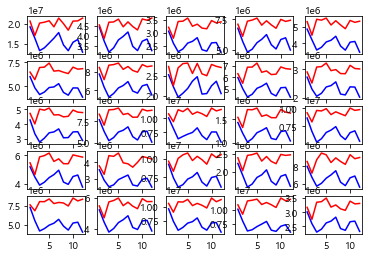

In [63]:
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.plot(plot_month, seoul_2020_df.iloc[:,i], color = 'blue')
    plt.plot(plot_month, seoul_2019_df.iloc[:,i], color = 'red')

# 하차

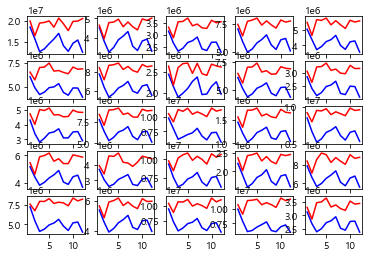

In [64]:
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.plot(plot_month, seoul_2020_ddf.iloc[:,i], color = 'blue')
    plt.plot(plot_month, seoul_2019_ddf.iloc[:,i], color = 'red')

##### 강남구 기준 T-test

In [65]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
levene = stats.levene(csv_month_2019[csv_month_2019['구명']=='강남구']['총승하차수'], 
                      csv_month_2020[csv_month_2020['구명']=='강남구']['총승하차수'])
print("LeveneResult( statistic = %.3f, pvalue = %.3f )" %levene)

LeveneResult( statistic = 2.025, pvalue = 0.169 )


#### 분산 동일성 검정 실행시 p 값이 0.1보다 크므로 두 그룹의 분산은 동일하다

In [66]:
subway_ttest = stats.ttest_ind(csv_month_2019[csv_month_2019['구명']=='강남구']['총승하차수'], 
                      csv_month_2020[csv_month_2020['구명']=='강남구']['총승하차수'])
print("t-value = %.3f, p-value = %.3f" % subway_ttest)

t-value = 7.116, p-value = 0.000


#### 유의한 차이가 있다. (두 그룹 간 차이가 없다는 귀무가설이 기각되었다.)

#### 서울시 전체구에 대해 진행

In [67]:
variance_p_list = []
for i in range(25):
    var = stats.levene(seoul_2019_tdf.iloc[:,i+1],seoul_2020_tdf.iloc[:,i+1])
    variance_p_list.append(var[1])

In [68]:
np.where(np.array(variance_p_list) < 0.1)

## 모든 구에서 분산이 동일하다

(array([], dtype=int64),)

In [70]:
gu_ttest_list = []
gu_ttest_p = []
for i in range(25):
    levene = stats.ttest_ind(seoul_2019_tdf.iloc[:,i+1],seoul_2020_tdf.iloc[:,i+1], equal_var = True)
    gu_ttest_list.append(levene[0])
    gu_ttest_p.append(levene[1])

In [71]:
print(gu_ttest_list)
print(gu_ttest_p)

[7.116234828369088, 6.314047134784637, 8.208457673995433, 7.745657496476573, 8.434878213089915, 9.400932004693324, 8.79007931477251, 6.282457446798109, 8.209599525859607, 8.20790455218541, 9.542237742965167, 8.611405822250193, 9.537671200718238, 8.452934124174707, 9.244511152386425, 7.525752708378123, 8.443821131742444, 8.420674365972092, 7.733981300021643, 7.844755767952469, 9.777400040858435, 7.781977682270691, 9.415121877846005, 9.975317320447395, 7.7146621626139655]
[3.892580547077538e-07, 2.3566430974654844e-06, 3.841371024971976e-08, 1.0050516849713544e-07, 2.4246237374820262e-08, 3.6696463676038234e-09, 1.194124429393779e-08, 2.533991530735831e-06, 3.8324017394434135e-08, 3.845723599611983e-08, 2.8119256816407206e-09, 1.7016835642558558e-08, 2.8361125693892004e-09, 2.3379478552553397e-08, 4.94171231869569e-09, 1.6033481037474907e-07, 2.3812868209281205e-08, 2.495135873825977e-08, 1.0301198735695154e-07, 8.160184728778979e-08, 1.81535781408231e-09, 9.310166727433509e-08, 3.572439

# 시각화

In [75]:
import json
import folium

In [76]:
m = folium.Map(
    location = [37.566345, 126.977893]) ## 서울시청의 위치
geo_json = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
data = pd.DataFrame({"gu":corr_list.keys()[:-1], "value":gu_ttest_list})
data

,gu,value
0,강남구,7.116235
1,강동구,6.314047
2,강북구,8.208458
3,강서구,7.745657
4,관악구,8.434878
5,광진구,9.400932
6,구로구,8.790079
7,금천구,6.282457
8,노원구,8.209600
9,도봉구,8.207905


# t-test 시각화

In [77]:
m = folium.Map(location = [37.566345, 126.977893], tiles = 'Stamen Terrain')
folium.Choropleth(geo_data = geo_json,
                 name = 'choropleth',
                 data= data,
                 columns = ['gu','value'],
                 key_on = 'feature.properties.name',
                 fill_color ='Blues',
                 fill_opacity = 0.7,
                 line_opacity=0.2).add_to(m)

m

# corr 시각화

In [78]:
## corr_df 정제
corr_df = corr_df.drop(['corona_people'])
corr_df

,gu,corr
구명,,
강남구,강남구,0.353835
강동구,강동구,0.357752
강북구,강북구,0.059296
강서구,강서구,0.059794
관악구,관악구,0.028056
광진구,광진구,-0.072988
구로구,구로구,0.009128
금천구,금천구,-0.055928
노원구,노원구,-0.053132


In [79]:
m = folium.Map(location = [37.566345, 126.977893], tiles = 'Stamen Terrain')
folium.Choropleth(geo_data = geo_json,
                 name = 'choropleth',
                 data= corr_df,
                 columns = ['gu','corr'],
                 key_on = 'feature.properties.name',
                 fill_color ='Blues',
                 fill_opacity = 0.7,
                 line_opacity=0.2).add_to(m)

m

In [80]:
# 결론 코로나로 인해 서울의 교통 이용자수는 코로나로 인해 영향을 받았고 그 중
# 강남부근이 가장 영향을 많이 받았음을 알 수 있었다,

# 기여도(총 100점) 및 역할

김창현 - 역할 : 상관관계 분석, 분산 분석, 데이터 시각화(지도, 그래프), 회귀 분석
기여도 - 자신의 역할(50) + 성실성(30) + 팀플 출석(20) = 100점 

강범창 - 데이터 전처리 및 데이터 수집(api), 프로젝트 총 정리
기여도 - 자신의 역할(50) + 성실성(30) + 팀플 출석(20) = 100점

고준수- 역할 : 분산 분석, 데이터 정규성 확인, 데이터 시각화(그래프)
기여도 - 자신의 역할(50) + 성실성(30) + 팀플 출석(20) = 100점